In [124]:
# Set the matplotlib magic. This line is specific to ipython notebooks.
%matplotlib widget

# Import some useful module.
import time
from matplotlib import pyplot as plt
from IPython.display import HTML
import numpy as np

# Import the system module.
import mag_lev

## Define Helpful Functions

In [164]:
# Converts duty cycle of EM to hall effect voltage
# using calibration curve
def duty_to_voltage_EM(duty):
    p = np.array([0.00781065, 2.480025585824681])
    return np.polyval(p,duty)

# Converts hall effect voltage to PM distance
# using calibration curve
def voltage_to_distance_PM(voltage,verbose=False):
    p = np.array([ 3426.53965926, -8498.10951529])
    l = np.polyval(p,voltage)
    if(verbose):
        print(l)
    if(l < 100):
        return 0.1
    return np.sqrt(1/l)

# Combines above two functions to get distance
# From hall effect voltage and duty pwm value
def hall2distance(voltage, duty,verbose=False):
    voltFromDuty = duty_to_voltage_EM(duty)
    VoltDiff = voltage - voltFromDuty
    if(verbose):
        print(VoltDiff + 2.480025585824681)
    return -1*voltage_to_distance_PM(VoltDiff + 2.480025585824681,verbose)

# Converts voltage to pwm
def voltage2pwm(voltage, Max):
    pwm = int((voltage/Max)*255)
    pwm = min(210,pwm)
    pwm = max(0,pwm)
    return pwm

# Returns value along step response of
# EM. dest is what you set the pwm to and
# curr is where you were when it was set
def EM_response(dest, curr, t):
    return (dest - (dest-curr)*np.exp((-1/0.006)*t))

## Run and Control the Simulation

In [171]:
#############################################################################################################################

#                                       Instantiate System and Controller Parameters

#############################################################################################################################

# Define constants
m = 3.00e-3 #[kg]
g = 9.8 #[m/s^2]
c_p = 8.03e-6 #[(m^2 * N)/V]

# Define equilibrium point
a = -2.0e-2
b = (m*g*(a ** 2))/(c_p)
pwm = voltage2pwm(b, 10)

# System input
pos_ref = 0

# Controller gains
Kp = 800
Kd = 20

#############################################################################################################################

#                                                      Simulate!

#############################################################################################################################

# Create the system object.
example_sys = mag_lev.MagLev()

# Start the system.
example_sys.start_system()

# Set the amplifier's maximum voltage.
example_sys.set_max_coil_voltage_magnitude(10.0)

# Set the amplifier's voltage.
example_sys.set_amplifier_input(pwm, example_sys.FORWARD)

# Choose an object mass.
example_sys.set_object_mass(m)

# Hold the magnet under the electromagnet.
example_sys.hold_magnet_at_distance(-a)

# Wait a moment and then release the magnet.
time.sleep(1.0)

# Watch what happens for a bit.
start_time = time.time()
end_time = 5.0

# Calculate initial error
error = pos_ref - (hall2distance(example_sys.get_hall_voltage(), pwm) - a)

# Get start time
t_now = time.time()

# Vectors to store data
x_vec = []
t_vec = []
pwm_vec = []
actual_pwm = pwm
prev_pwm = pwm

# Get first time stamp to use in accounting for coil dynamics
t1 = time.time() - start_time

# Release the magnet!
example_sys.release_magnet()
while time.time() - start_time < end_time:
    
    # Account for coil dynamics 
    t2 = time.time() - start_time
    actual_pwm = EM_response(pwm, actual_pwm, t2-t1)
    
    # Calculate Distance
    hall = example_sys.get_hall_voltage()
    x_t = hall2distance(hall, actual_pwm)
    x_vec.append(x_t)
    
    # Calculate a dt and store time
    dt = time.time() - t_now
    t_now = time.time()
    t_vec.append(t_now - start_time)
    
    # Calculate error derivative
    errorD = ((pos_ref - (x_t - a)) - error) / dt
    
    # Update error
    error = pos_ref - (x_t - a)
    
    # Calculate new voltage
    voltage = Kp*error + Kd*errorD + b
    
    # Store previous PWM and calculate new PWM
    # From new voltage
    prev_pwm = pwm
    pwm = voltage2pwm(voltage, 10)
    
    # pwm_vec.append(pwm)
        
    # Account for EM lag
    t1 = time.time() - start_time
    actual_pwm = EM_response(prev_pwm, actual_pwm, t1 - t2)
    
    # Set the amplifier's voltage.
    example_sys.set_amplifier_input(pwm, example_sys.FORWARD)
    
# Remove Magnet
example_sys.remove_magnet()

# Wait a moment and stop the system.
time.sleep(1.0)
example_sys.stop_system()

# Note that all the other waits were as desired except the following wait
# as the system will not give an animation if the system is not fully
# stopped.
time.sleep(1.0)

Starting system...
System started
System stopped


## Animate the Simulation

In [172]:
anim = example_sys.create_system_animation();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot Some Data To Examine

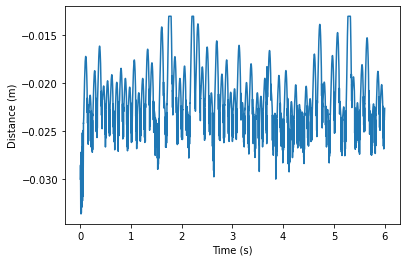

In [123]:
plt.plot(t_vec,x_vec)
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.show()

## Save and Play Higher Quality Video

In [173]:
anim_video = HTML(anim.to_html5_video())

In [174]:
anim_video